In [13]:
#Code for loading edf files and calculating some of the properties

In [14]:
!pip install mne

In [15]:
import mne
import matplotlib.pyplot as plt
import math
import numpy as np
import numpy.ma as ma

In [9]:
import mne
file = r"chb01_01.edf" #change this to the location of your file
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
info = data.info
channels = data.ch_names
print(raw_data.shape)

Extracting EDF parameters from /Users/lyz/Documents/VSCode_Workspace/StemForAll/Medical Data/chb01_01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
(23, 921600)


/var/folders/7v/fsvkddxs13l61jh8r5wdb54h0000gn/T/ipykernel_39376/199064426.py:3: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  data = mne.io.read_raw_edf(file)


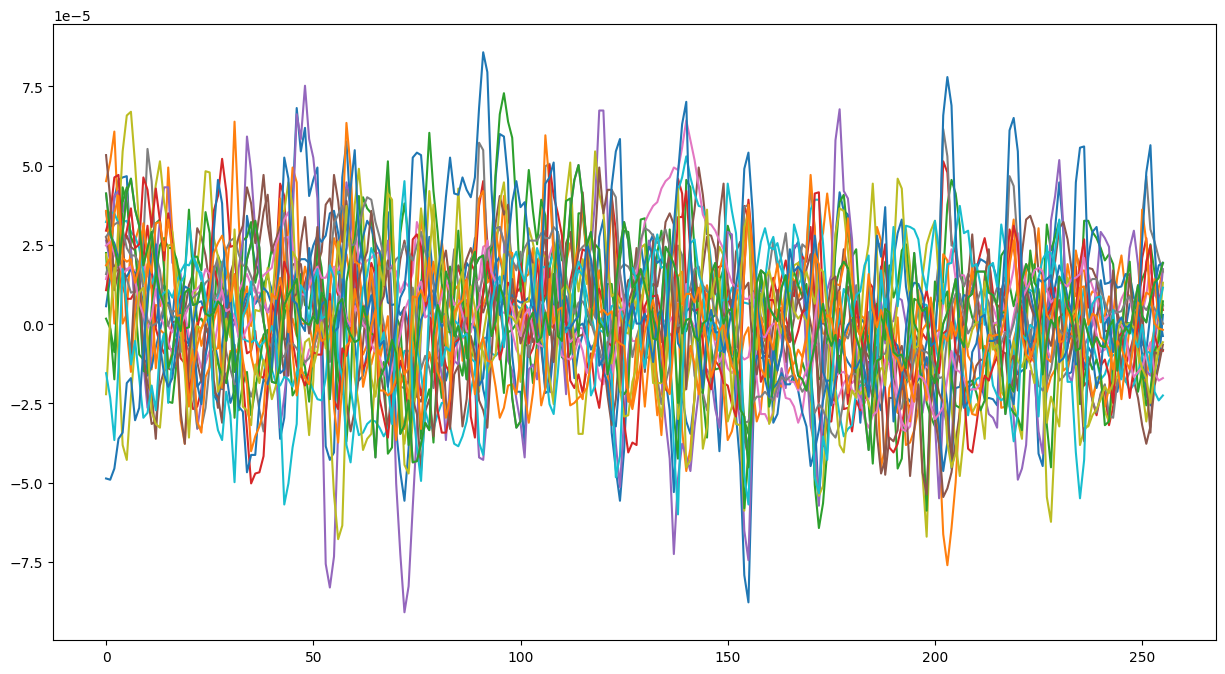

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
time_start = 2999 * 256
time_end = 3000 * 256

for i in range(len(channels)):
    plt.plot(raw_data[i][time_start:time_end], label=f'channel{i}')


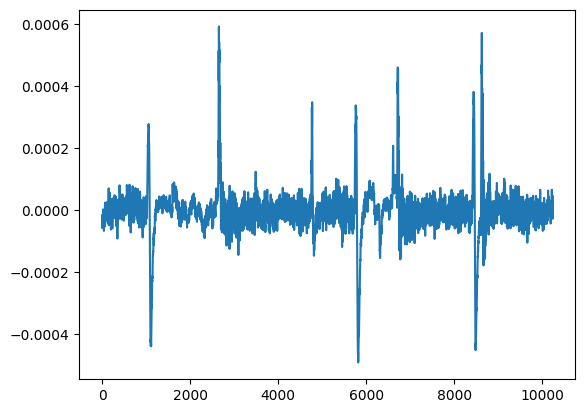

In [ ]:
plt.plot(raw_data[0][2996 * 256:3036 * 256]) #First index is the channel, second is the time period (256 points recorded per second)

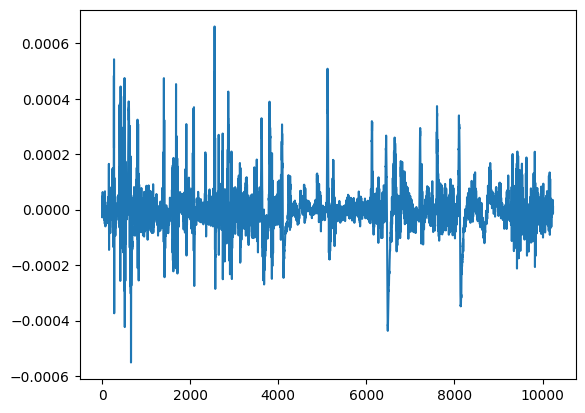

In [18]:
plt.plot(raw_data[0][2000 * 256:2040 * 256])

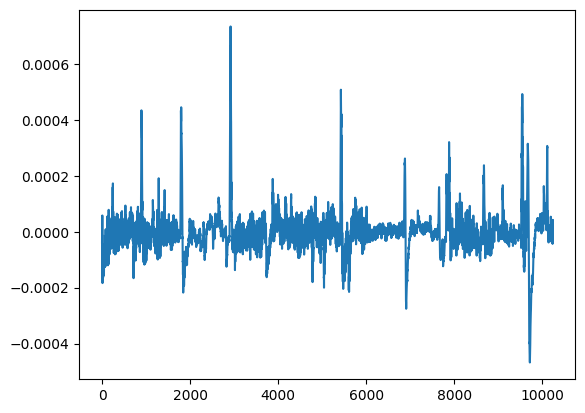

In [19]:
plt.plot(raw_data[0][1000 * 256:1040 * 256])

In [20]:
#Discrete energy calculation

def discrete_energy(data, s):
    d_e = 0
    for t1 in range(data.shape[1]):
        for t2 in range(t1 + 1, data.shape[1]):
            x = np.sqrt(np.sum(np.square(data[:, t1] - data[:, t2])))
            d_e += x ** (-1 * s) if x != 0 else 0
    return d_e

def DiscreteSEnergy(P, s):
    n = np.shape(P)[0]

    [Rows, Columns] = np.indices((n,n))

    VecDiff = np.abs(P[Rows,:] - P[Columns,:])

    MagDiff = np.power(np.sum(np.power(VecDiff,2), axis=2),1/2) #here we use L2 norm (Euclidean distance in Rd) to find vector magnitude

    Diff= np.triu(MagDiff) #remove duplicate differences by considering only those differences above the main diagonal
    MaskedDiff = ma.masked_where(Diff==0, Diff, copy=True) #mask all zero differences so we are not dividing by zero

    SumMat = np.ma.power(MaskedDiff, -s)
    sum = np.sum(np.sum(SumMat))

    discSEnergy = np.power(float(n), -2)*sum

    return[discSEnergy, s]

#Testing with the data from one second
test_data = raw_data[:, 10000:10000 + 256] / np.max(np.abs(raw_data)) #normalize
print(DiscreteSEnergy(test_data, 23.5))
print(DiscreteSEnergy(test_data[:, ::2], 23.5)) #calculation with only half as many points

print(discrete_energy(test_data, 23.5))
print(discrete_energy(test_data[:, ::2], 23.5))

[np.float64(2.1483172689142016e+16), 23.5]
[np.float64(8.653074086212846e+19), 23.5]
9.865055538519117e+43
1.860261079195836e+36


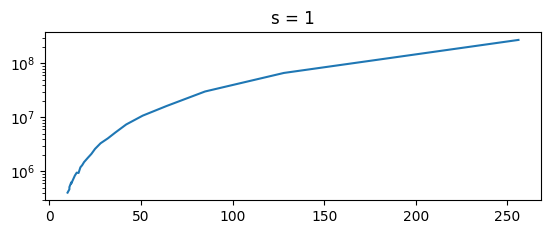

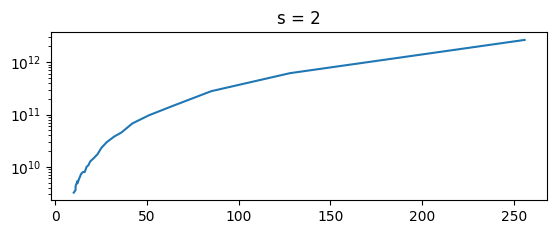

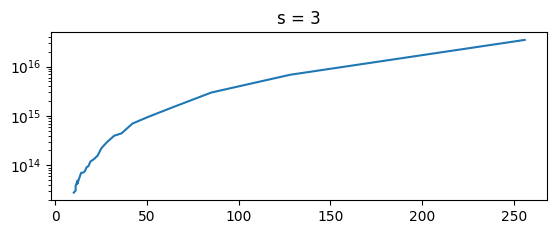

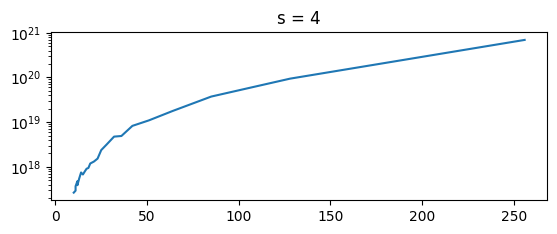

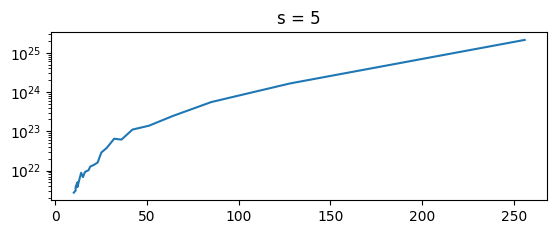

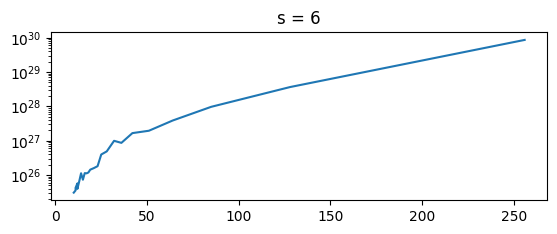

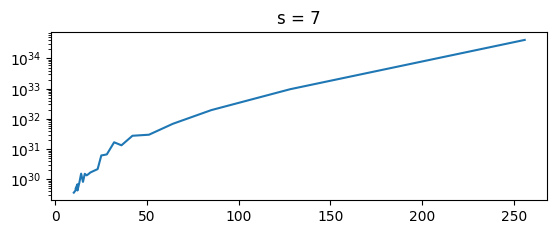

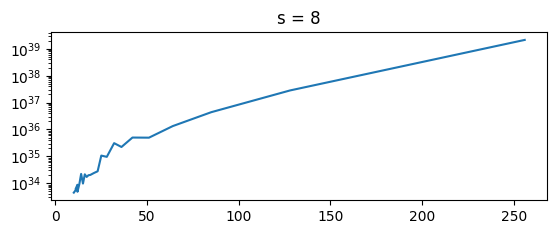

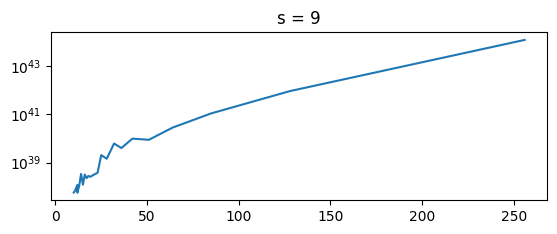

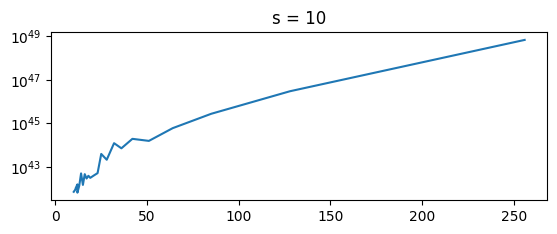

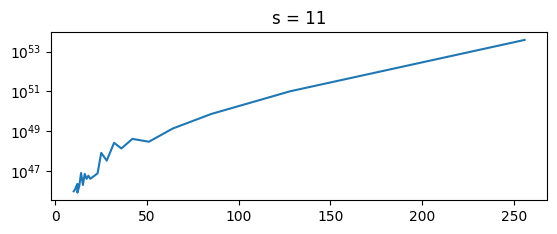

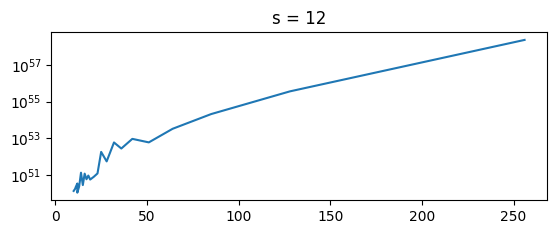

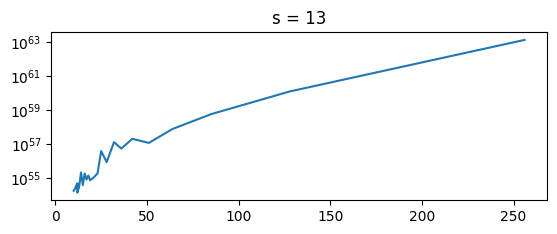

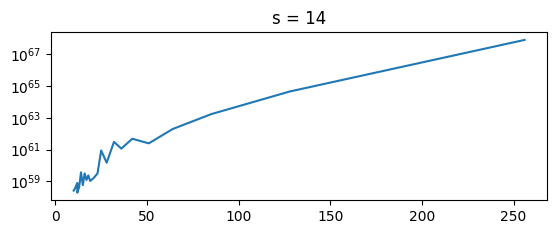

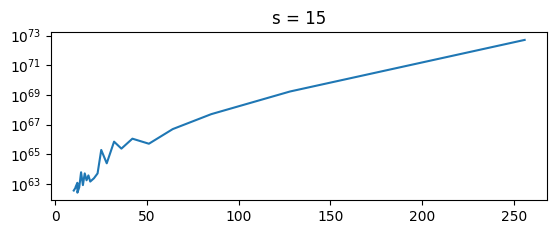

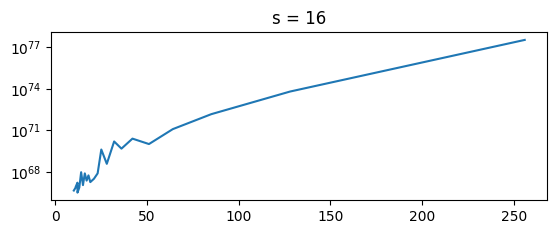

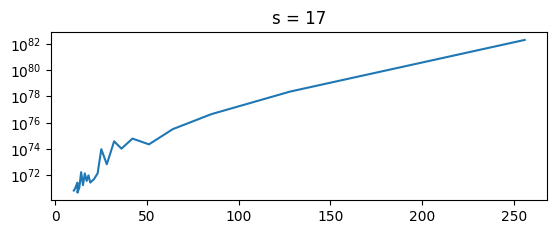

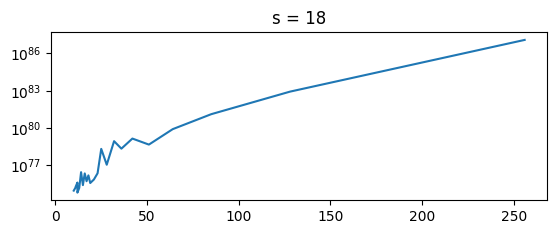

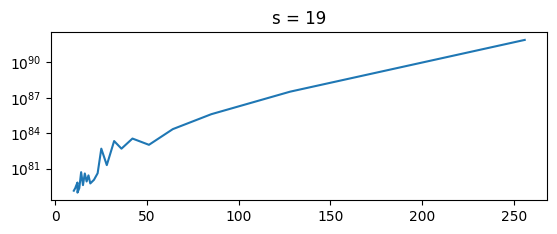

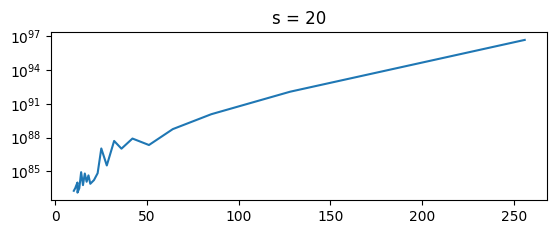

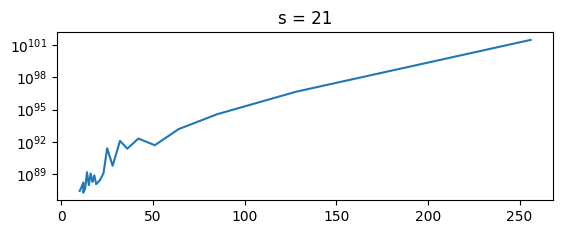

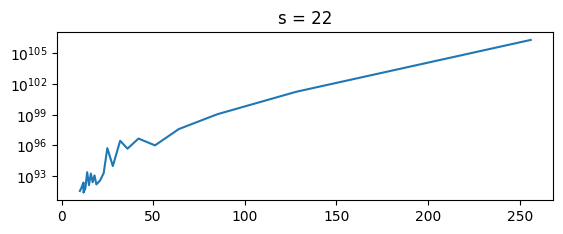

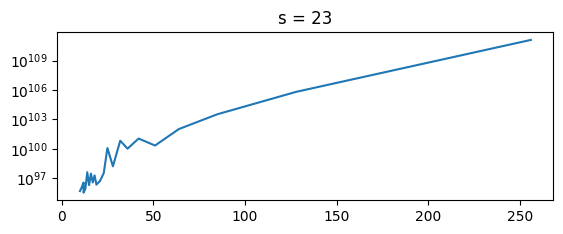

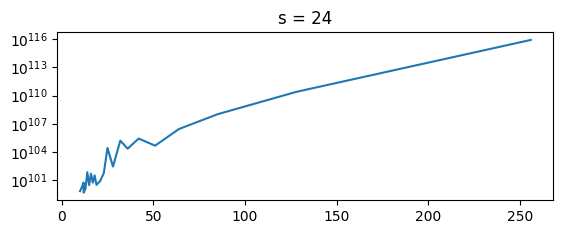

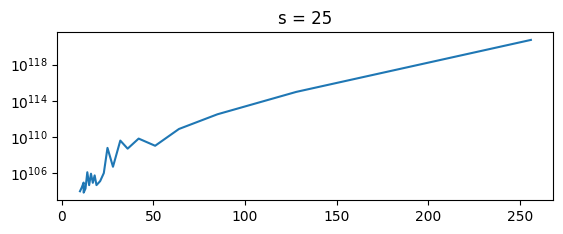

In [21]:
#Include a time vector

def energy_graph(data, s):
    #data = np.vstack([data, np.array([i for i in range(1, data.shape[1] + 1)]) / 256])
    d_e_list = []
    x_list = []
    maxN = data.shape[1]
    for i in range(1, maxN // 10): #could cause issues
        d_e_list.append(discrete_energy(data[:, ::i], s))
        x_list.append(maxN // i)
    plt.subplot(2,1,1)
    plt.plot(x_list, d_e_list)
    plt.yscale('log')
    #plt.xscale("log")
    plt.title(f"s = {s}")
    plt.show()

def energy_graph_2(data, s):
    d_e_list = []
    x_list = []
    maxN = data.shape[1]
    for i in range(1, maxN // 10): #could cause issues
        d_e_list.append(DiscreteSEnergy(data[:, ::i], s))
        x_list.append(maxN // i)
    plt.subplot(2,1,1)
    plt.plot(x_list, [i for i, j in d_e_list])
    plt.yscale('log')
    plt.title(f"s = {s}")
    plt.show()

#Area of the dataset without a seizure

for s in range(1, 26):
    energy_graph(raw_data[:, 2000:2256], s)

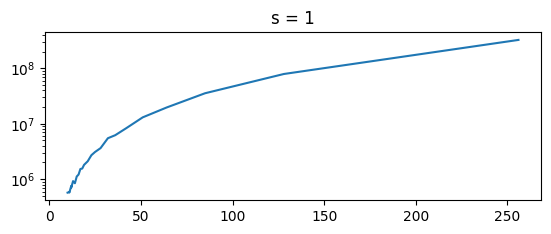

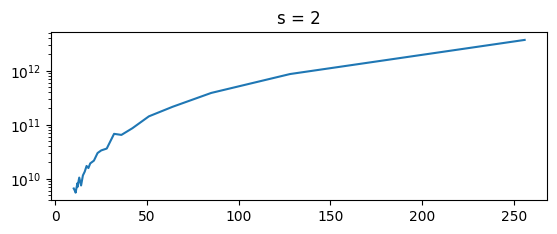

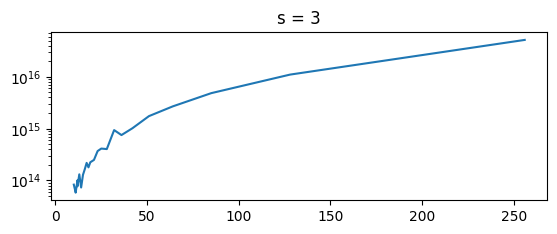

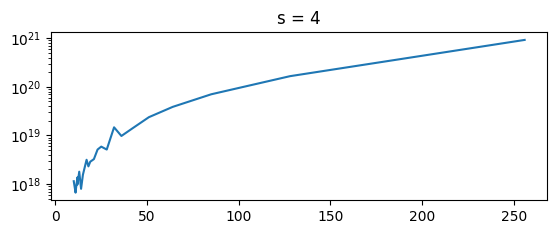

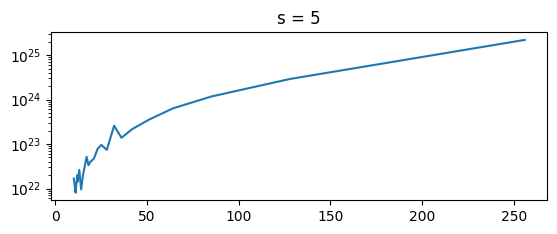

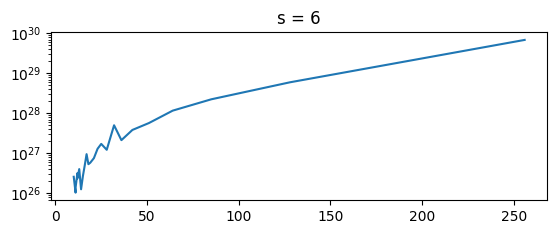

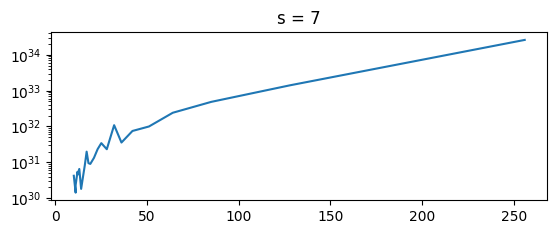

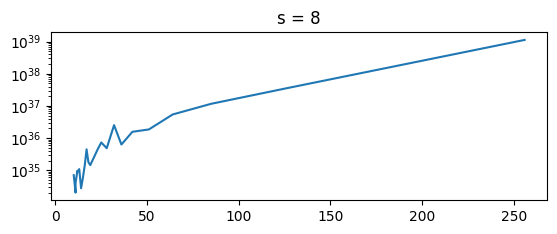

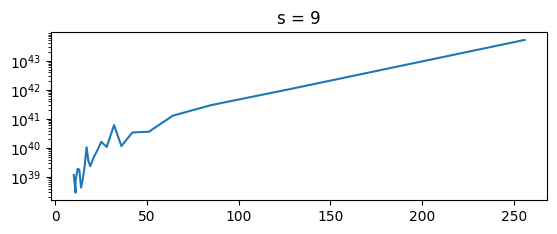

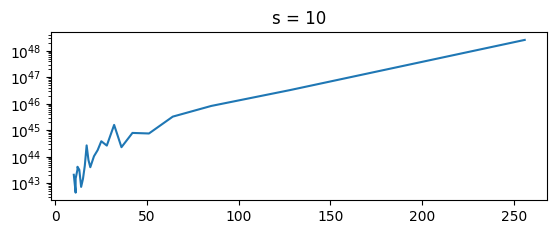

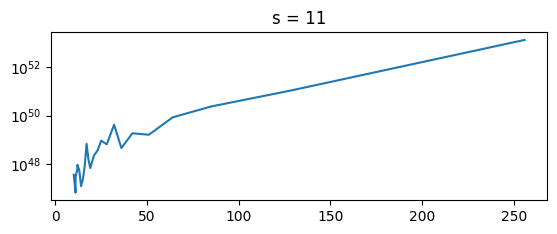

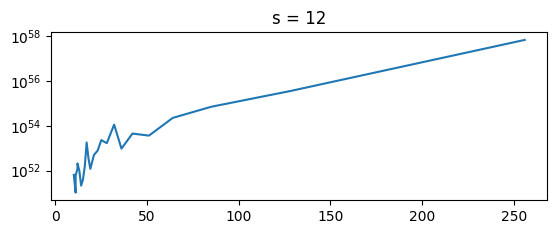

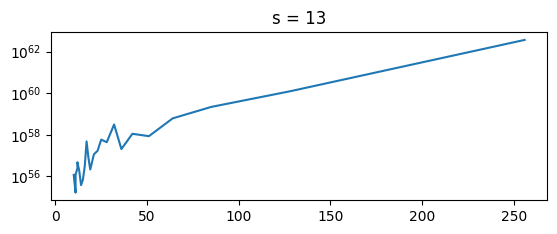

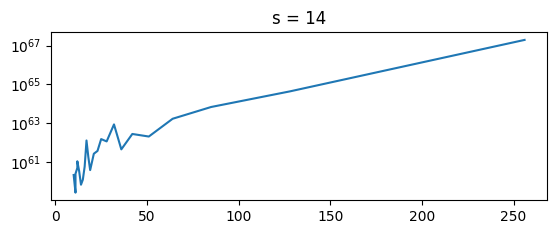

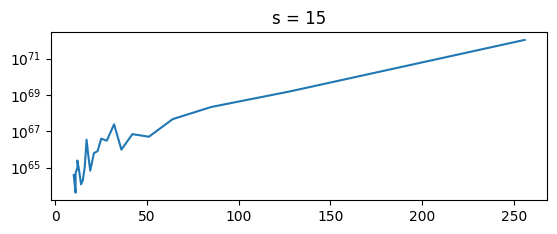

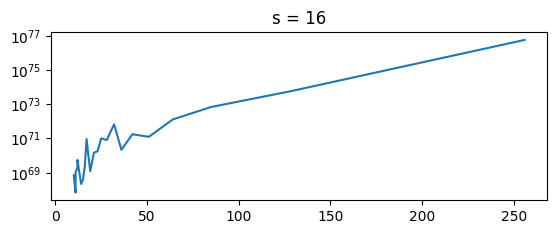

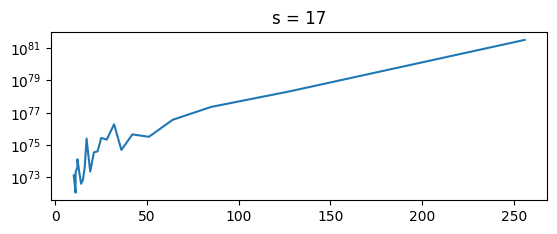

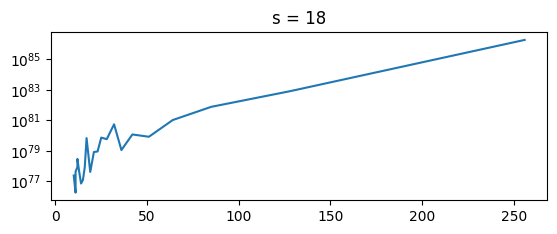

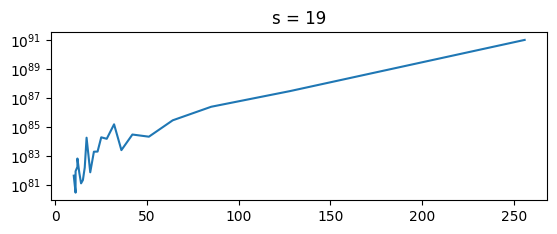

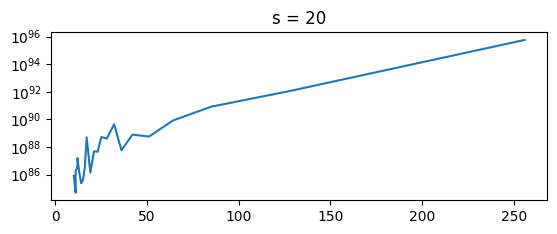

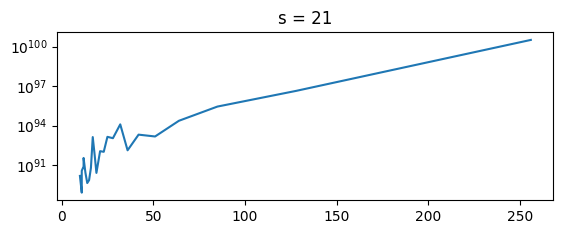

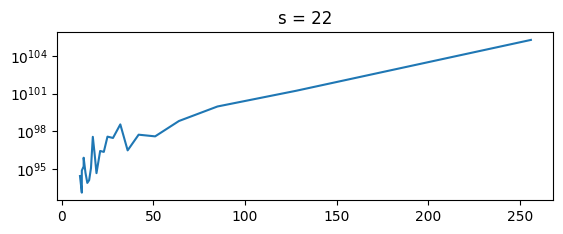

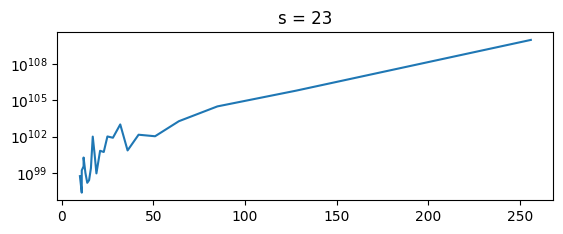

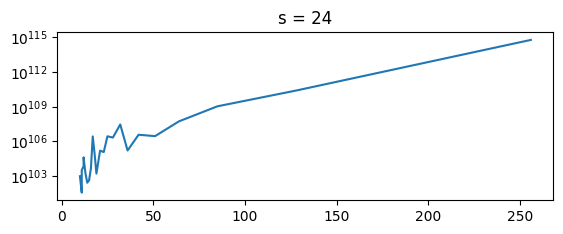

In [22]:
#Seizure area of the dataset

for s in range(1, 25):
    energy_graph(raw_data[:, 3001 * 256:(3001 * 256 + 256)], s)

In [23]:
#Stolen from here: https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e

def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

for i in range(23):
    print(get_hurst_exponent(raw_data[i][10000:]))

0.30979519863332927
0.16029744996488357
0.10461715727855737
0.27170629670316476
0.24781243376102502
0.1752526941629906
0.2111728022981394
0.24745372530942294
0.21968831305788525
0.28435273977663295
0.24078957625586053
0.27919818646287525
0.26424888873928754
0.17826614400220162
0.160160977543645
0.2483305806217893
0.5120536690471965
0.5203984736455914
0.10461715727855737
0.05898364059263474
0.2892111771994168
0.1693837166026835
0.160160977543645


In [24]:
#This code is to parse the seizure timings 
#Shouldn't need to run it since you can just load the seizure_times.pkl file as shown below
#Note: chb07/chb07_18.edf has no seizures despite being in RECORDS-WITH-SEIZURES

folder = "chb-mit-scalp-eeg-database-1.0.0\\"

seizure_sessions = []
with open(r"chb-mit-scalp-eeg-database-1.0.0\RECORDS-WITH-SEIZURES", "rb") as f:
    seizure_sessions = [i for i in f.read().decode("utf-8").split("\n") if len(i) > 0]

seizure_times = dict()
for file in seizure_sessions:
    patient, edf = file.split("/")
    
    summary = open(f"{folder}{patient}\\{patient}-summary.txt").read().split("\n\n")
    info = [i for i in summary if edf in i][0]
    times_lines = [int([j for j in i.split(" ")[2:] if j.isdecimal()][0]) for i in info.split("\n") if "Seizure " in i]
    times = [(times_lines[i], times_lines[i + 1]) for i in range(0, len(times_lines), 2)]
    if len(times) > 0:
        seizure_times[file] = times

FileNotFoundError: [Errno 2] No such file or directory: 'chb-mit-scalp-eeg-database-1.0.0\\RECORDS-WITH-SEIZURES'

In [3]:
print(seizure_sessions)

NameError: name 'seizure_sessions' is not defined

In [4]:
seizure_times

NameError: name 'seizure_times' is not defined

In [5]:
import pickle

with open("seizure_times.pkl", "wb") as f:
    pickle.dump(seizure_times, f)

NameError: name 'seizure_times' is not defined

In [ ]:
with open("seizure_times.pkl", "rb") as f:
    seizures = pickle.load(f)

In [ ]:
#Not sure what this code below was for

In [ ]:
def energy_graph_channel(data, s):
    #data = np.vstack([data, np.array([i for i in range(1, data.shape[1] + 1)]) / 256])
    d_e_list = []
    x_list = []
    maxN = len(data)
    for i in range(1, maxN // 10): #could cause issues
        d_e_list.append(DiscreteSEnergy(data[::i], s))
        x_list.append(maxN // i)
    plt.subplot(2,1,1)
    plt.plot(x_list, d_e_list)
    #plt.yscale('log')
    #plt.xscale("log")
    plt.title(f"s = {s}")
    plt.show()

energy_graph_channel(raw_data[0, 10000:10256], 1)